# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

# Setup

In [2]:
sns.set() #Adjust Plots
filterwarnings('ignore')
colors = sns.color_palette()

# Functions

In [2]:
def etl(filename, countries_only = False):
    
    """

    This function will Extract, Transform and Load
    the data from the World Bank Energy .xlsx file

    Parameters
    ----------
    filename : str
        path to the .xlsx file
        
    countries_only : str, optional
        if set to True, will drop continents,
        geopolitical and geoeconomic groups.
        e.g. World, G7, BRICS ...

    Returns
    -------
    sheets : list
        Contains the keys to get the data
        from the 'Dfs' dictionary
        
    Dfs : Dictionary of pandas DataFrame
        Dictionary containing the structured data from the sheets.

    """
    
    #Initial Variables
    Dfs = {}
    
    not_countries = ["World", "OECD", "G7", "BRICS", "Europe",
        "European Union", "CIS", "Asia", "North America",
        "Latin America", "Australasia", "Africa", "Middle-East"]
    
    #Open and Get Sheet names from .xlsx file
    file = pd.ExcelFile(filename) #Open
    sheets = file.sheet_names[1:-3] #Exclude First and Last Three columns
    file.close() #Close

    #Iterate to get all of the DataFrames
    for sheet in sheets:
        df = pd.read_excel(filename, sheet_name = sheet, header = 2) #Read
        df = df[:-3] #Drop Last 3 Rows, since they are not part of the data
        df.rename(columns = {"Unnamed: 0": "Location"}, #Rename first column
                  inplace = True)
        
        # Some columns are written in terms of variation, e.g.:
        # '2016 - 2017 (%)' or '2016 - 2017 (points)'
        # These columns have missing values that, so far,
        # are not being used in the analysis. 
        # Besides, if necessary, they can be easily reconstructed
        # with pandas' methods
        drop = [col for col in df.columns if "-" in str(col)]
        df.drop(drop, axis = 1, inplace = True)
        
        if countries_only:
            df = df.query('Location not in @not_countries')
            df.reset_index(drop = True, inplace = True)
            
        Dfs[sheet] = df #Save to Dictionary

    #Return names and data
    return sheets, Dfs

def plotting_prep(df, location, rename_to):
    
    """
    
    This function will query info from a specific location
    to assist line plotting in (Year, Value) pairs
    
    Parameters
    ----------
    df : pandas DataFrame
        DataFrame to query data from 
    location : str
        Country, Geopolitical or Geoeconomic Group used to query data.
        e.g. Brazil, G7, BRICS ...
    rename_to : str
        How the column will be named once the Transformation is complete.

    Returns
    -------
    locat_df : pandas DataFrame
        Transformed pandas DataFrame

    """
    
    locat_df = df.query(f"Location == '{location}'") #Filter Location
    locat_df = locat_df.drop("Location", axis = 1).T #Drop column and Transpose
    locat_df.reset_index(inplace = True) #Reset Index for Plotting
    locat_df.columns = ["Year", f"{rename_to}"] #Rename Columns
    
    return locat_df

# Data Analysis

## Read File

In [4]:
filename = "enerdata_energy_statistical_yearbook_2018.xlsx"
Names, Dfs = etl(filename, countries_only = True)

In [5]:
Names

['Total energy production',
 'Energy balance of trade',
 'Total energy consumption',
 'Energy intensity of GDP',
 'Crude oil production',
 'Crude oil balance of trade',
 'Crude oil input to refineries',
 'Refined oil products productio',
 'Oil products balance of trade',
 'Oil products domestic consumpt',
 'Natural gas production',
 'Natural gas balance of trade',
 'Natural gas domestic consumpti',
 'Coal and lignite production',
 'Coal and lignite balance of tr',
 'Coal and lignite domestic cons',
 'Electricity production',
 'Electricity balance of trade',
 'Electricity domestic consumpti',
 'Share of renewables in electri',
 'Share of wind and solar in ele',
 'CO2 emissions from fuel combus',
 'CO2 intensity']

## Energy Production vs. Consumption

### Data Prep

In [6]:
#Energy Production DataFrame
enerprod = 'Total energy production'
enerprod = Dfs[enerprod]
enerprod.iloc[:,1:] *= 11.63 #Convert from Mtoe to TWh
br_enerprod = plotting_prep(df = enerprod,
                            location = "Brazil",
                            rename_to = "Production")

In [7]:
#Energy Consumption DataFrame
enercons = 'Total energy consumption'
enercons = Dfs[enercons]
enercons.iloc[:,1:] *= 11.63 #Convert from Mtoe to TWh
br_enercons = plotting_prep(df = enercons,
                            location = "Brazil",
                            rename_to = "Consumption")

### Plot

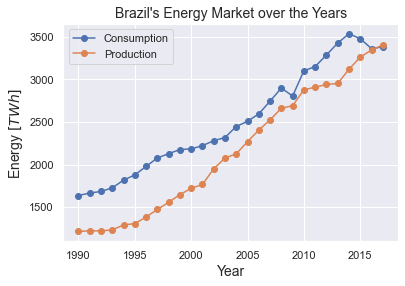

In [8]:
fig, ax = plt.subplots()
ax.plot("Year", "Consumption", "o-", data = br_enercons)
ax.plot("Year", "Production", "o-", data = br_enerprod)

ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Energy $[TWh]$", fontsize = 14)
ax.set_title("Brazil's Energy Market over the Years", fontsize = 14)
ax.legend()

## Eletricity Production vs. Consumption

### Data Prep

In [9]:
#Eletricity Production DataFrame
eletprod = 'Electricity production'
eletprod = Dfs[eletprod]
br_eletprod = plotting_prep(df = eletprod,
                            location = "Brazil",
                            rename_to = "Production")

In [10]:
#Eletricity Consumption DataFrame
eletcons = 'Electricity domestic consumpti'
eletcons = Dfs[eletcons]
br_eletcons = plotting_prep(df = eletcons,
                            location = "Brazil",
                            rename_to = "Consumption")

### Plot

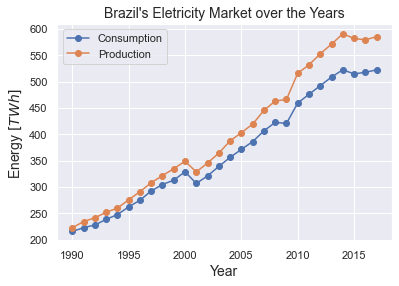

In [11]:
fig, ax = plt.subplots()
ax.plot("Year", "Consumption", "o-", data = br_eletcons)
ax.plot("Year", "Production", "o-", data = br_eletprod)

ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Energy $[TWh]$", fontsize = 14)
ax.set_title("Brazil's Eletricity Market over the Years", fontsize = 14)
ax.legend()

## Renewables vs. Other Sources

In [12]:
renew_share = 'Share of renewables in electri'
renew_share = Dfs[renew_share]

In [13]:
renew = renew_share.copy()
not_renew = renew_share.copy()

renew.iloc[:,1:] = eletprod.iloc[:,1:] * renew_share.iloc[:,1:]/100
not_renew.iloc[:,1:] = eletprod.iloc[:,1:] - renew.iloc[:,1:]

In [14]:
br_renew = plotting_prep(df = renew,
                         location = "Brazil",
                         rename_to = "Renewables")

br_notrenew = plotting_prep(df = not_renew,
                            location = "Brazil",
                            rename_to = "Not Renewables")

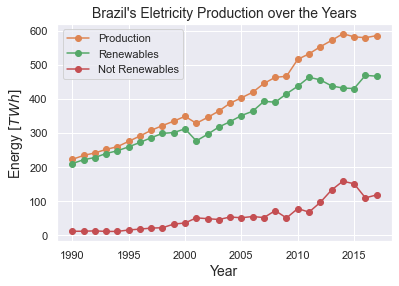

In [15]:
fig, ax = plt.subplots()
ax.plot("Year", "Production", "o-", data = br_eletprod, color = colors[1])
ax.plot("Year", "Renewables", "o-", data = br_renew, color = colors[2])
ax.plot("Year", "Not Renewables", "o-", data = br_notrenew, color = colors[3])

ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Energy $[TWh]$", fontsize = 14)
ax.set_title("Brazil's Eletricity Production over the Years", fontsize = 14)
ax.legend()

## Top 10 Countries in Renewables Sources in 2017

In [16]:
countries2017 = renew_share[["Location",2017]]
countries2017.sort_values(2017, ascending = False,
                          inplace = True, ignore_index = False)

top10renew = countries2017[:10]
top10renew

,Location,2017
12,Norway,97.870054
24,Colombia,86.776805
37,New Zealand,81.391550
22,Brazil,79.706358
19,Canada,64.707373
26,Venezuela,63.331727
10,Sweden,57.526666
23,Chile,44.496222
7,Portugal,39.749372
8,Romania,38.699549


## Countries with Higher Renewables Share than Brazil

In [18]:
#Get Countries with Higher Renewables Share than Brazil
brazil_share = top10renew.query("Location == 'Brazil'")[2017].iloc[0]
bol = countries2017[2017] >= brazil_share
countries_above_brazil = renew_share[bol]

#Transform to Assist Plotting
countries_above_brazil = countries_above_brazil.set_index("Location").T

Text(0.5, 1.0, 'Countries with Higher Renewables Share than Brazil along the Years')

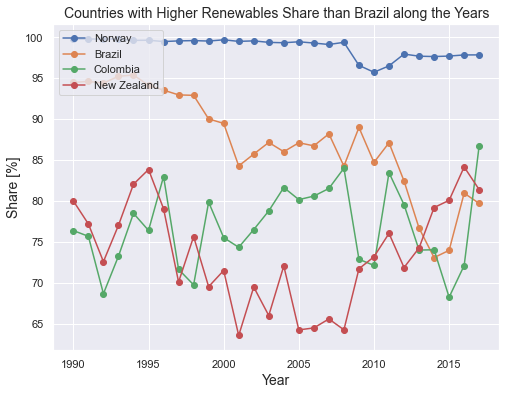

In [25]:
fig, ax = plt.subplots(figsize = (8,6))
countries_above_brazil.plot(style = "o-", ax = ax)

ax.set_xlabel("Year", fontsize = 14)
ax.set_ylabel("Share [%]", fontsize = 14)
ax.legend(loc = 2)
title = "Countries with Higher Renewables Share than Brazil along the Years"
ax.set_title(title, fontsize = 14)